In [2]:
!pip install amplpy pyomo -q
!python -m amplpy.modules install coin highs scip gcg -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import requests

# Data for Gas Cars
gas_cars = {
    "Vehicle": "Gas Car",
    "Freight Rate [COP/km]": 5000,
    "Time Rate [COP/min]": 500,
    "Daily Maintenance [COP/day]": 30000,
    "Recharge/Fuel Cost [COP/(gal or kWh)]": 16000,
    "Recharge/Fuel Time [min/10 percent charge]": 0.1,
    "Avg. Speed [km/h]": None,
    "Gas Efficiency [km/gal]": 10,
}

# Data for Drones
drones = {
    "Vehicle": "Drone",
    "Freight Rate [COP/km]": 500,
    "Time Rate [COP/min]": 500,
    "Daily Maintenance [COP/day]": 3000,
    "Recharge/Fuel Cost [COP/(gal or kWh)]": 220.73,
    "Recharge/Fuel Time [min/10 percent charge]": 2,
    "Avg. Speed [km/h]": 40,
    "Gas Efficiency [km/gal]": None,
    "Electricity Efficency [kWh/km]": 0.15,
}


# Data for Solar EVs
solar_ev = {
    "Vehicle": "Solar EV",
    "Freight Rate [COP/km]": 4000,
    "Time Rate [COP/min]": 500,
    "Daily Maintenance [COP/day]": 21000,
    "Recharge/Fuel Cost [COP/(gal or kWh)]": None,
    "Recharge/Fuel Time [min/10 percent charge]": None,
    "Avg. Speed [km/h]": None,
    "Gas Efficiency [km/gal]": None,
    "Electricity Efficency [kWh/km]": 0.15,
}



In [4]:
import math


depots_df = pd.read_csv('Depots.csv')
clients_df = pd.read_csv('Clients.csv')


#depots_df = pd.read_csv('smalldepots.csv')
#clients_df = pd.read_csv('smallclients.csv')

# extract coordinates
depots_coords = depots_df[['Longitude', 'Latitude']].values.tolist()
clients_coords = clients_df[['Longitude', 'Latitude']].values.tolist()

# Combine depots and clients
all_coords = depots_coords + clients_coords

# Build the coordinates string for OSRM
coords_str = ';'.join([f"{lon},{lat}" for lon, lat in all_coords])




# API URL
url = f"https://router.project-osrm.org/table/v1/driving/{coords_str}"

# Parameters
params = {
    'sources': ';'.join(map(str, range(len(all_coords)))),
    'destinations': ';'.join(map(str, range(len(all_coords)))),
    'annotations': 'duration,distance'
}

# Send the request
response = requests.get(url, params=params)

# Check for successful response
if response.status_code != 200:
    print(f"Error: {response.status_code}")
    print(response.text)
    exit()

data = response.json()

# Extract the distance matrix
car_matrix_distance = np.array(data['distances'])
car_matrix_distance = car_matrix_distance / 1000

#The distance matrix gives the distance in km from node i to node j.

# Extract the duration matrix
car_matrix_time = np.array(data['durations'])
car_matrix_time = car_matrix_time / 60

#The duration matrix gives the time in minutes from node i to node j.




def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

nodes = all_coords

drone_matrix = [[0 for _ in range(len(nodes))] for _ in range(len(nodes))]
#The drone matrix gives the distance in km from node i to node j if a drone is used.

for i in range(len(nodes)):
    for j in range(len(nodes)):
        if i != j:
            origin = nodes[i]
            destination = nodes[j]
            origin_latitud = origin[1]
            origin_longitud = origin[0]
            destination_latitud = destination[1]
            destination_longitud = destination[0]
            drone_matrix[i][j] = haversine(origin_longitud, origin_latitud, destination_longitud, destination_latitud)

drone_matrix_distance = np.array(drone_matrix)

drone_matrix_time = drone_matrix_distance / drones["Avg. Speed [km/h]"]
drone_matrix_time = drone_matrix_time * 60

#No cars anc clients no more. We gonna use dataframes


cars_df = pd.read_csv("Vehicles.csv")

num_depots = len(depots_coords)

depots_df["LocationID"] = depots_df["LocationID"] - 1
clients_df["LocationID"] = clients_df["LocationID"] - 1

first_client = clients_df["LocationID"].iloc[0]
last_client = clients_df["LocationID"].iloc[-1]



np.fill_diagonal(car_matrix_distance, 9999999)
np.fill_diagonal(car_matrix_time, 9999999)
np.fill_diagonal(drone_matrix_distance, 9999999)
np.fill_diagonal(drone_matrix_time, 9999999)




num_cars = len(cars_df)


print(depots_df)
print(clients_df)





    DepotID  LocationID  Longitude  Latitude
0         1           0 -74.081242  4.750212
1         2           1 -74.109934  4.536383
2         3           2 -74.038548  4.792926
3         4           3 -74.067069  4.721678
4         5           4 -74.138263  4.607707
5         6           5 -74.124002  4.650463
6         7           6 -74.095619  4.621912
7         8           7 -74.109756  4.678961
8         9           8 -74.095472  4.735973
9        10           9 -74.109916  4.550641
10       11          10 -74.109774  4.664703
11       12          11 -74.124089  4.579174
    ClientID  LocationID  Product  Longitude  Latitude
0          1          12       13 -74.098938  4.597954
1          2          13       15 -74.075571  4.687821
2          3          14       12 -74.107085  4.709494
3          4          15       15 -74.097280  4.605029
4          5          16       20 -74.164641  4.648464
5          6          17       17 -74.120838  4.662137
6          7          18      

In [5]:
from __future__ import division
from pyomo.environ import *
import pandas  as pd
from pyomo.opt import SolverFactory
import networkx as nx
from matplotlib import pyplot as plt
from amplpy import modules
from pyomo.util.model_size import build_model_size_report

class BaseCase:
    def __init__(self, gas_cars, drones, solar_ev, car_matrix_distance, car_matrix_time, drone_matrix_distance, drone_matrix_time, cars, clients, num_depots, first_client, last_client, num_cars):
        """
        Initialize the model parameters.
        """
        self.gas_cars = gas_cars
        self.drones = drones
        self.solar_ev = solar_ev
        self.car_matrix_distance = car_matrix_distance
        self.car_matrix_time = car_matrix_time
        self.drone_matrix_distance = drone_matrix_distance
        self.drone_matrix_time = drone_matrix_time
        self.cars = cars
        self.clients = clients
        self.num_depots = num_depots
        self.first_client = first_client
        self.last_client = last_client
        self.num_cars = num_cars


        # Create the Pyomo model
        self.model = ConcreteModel()

    def build_model(self):
        """
        Build the optimization model.
        """
        model = self.model

        # Sets
        model.depots_set = RangeSet(0, self.num_depots-1) #Set of depots. In the cost_matrix, the depots come first
        model.clients_set = RangeSet(self.first_client, self.last_client) #Set of clients. In the cost matrix, the clients come after the depots.
        model.nodes = RangeSet(0, self.last_client) #Set of nodes. This includes both depots and clients.
        model.cars_set = RangeSet(0, self.num_cars-1) #Set of vehicles.


        #Decision Variables
        model.x = Var(model.nodes, model.nodes, model.cars_set, domain=Binary)
        model.u = Var(model.clients_set, model.cars_set, domain=NonNegativeReals, bounds = (0, len(model.nodes)-1))




        # Objective: Minimize total cost (energy, installation, and communication costs)
        def obj_expression(model):
            cost1 = 0
            for k in model.cars_set:
                cost1 += sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set)*500/2
            #Revised with JD

            #Cost of driving the car (distance)
            cost2 = 0
            for i in model.nodes:
                for j in model.nodes:
                    for k in model.cars_set:
                        if self.cars['VehicleType'].iloc[k] == "Gas Car":
                            cost2 += self.car_matrix_distance[i][j]*model.x[i,j,k]*self.gas_cars["Freight Rate [COP/km]"]
                        elif self.cars["VehicleType"].iloc[k] == "drone":
                            cost2 += self.drone_matrix_distance[i][j]*model.x[i,j,k]*self.drones["Freight Rate [COP/km]"]
                        elif self.cars["VehicleType"].iloc[k] == "EV":
                            cost2 += self.car_matrix_distance[i][j]*model.x[i,j,k]*self.solar_ev["Freight Rate [COP/km]"]
            #Revised with JD

            #Cost of driving the car (time)
            cost3 = 0
            for i in model.nodes:
                for j in model.nodes:
                    for k in model.cars_set:
                        if self.cars["VehicleType"].iloc[k] == "Gas Car":
                            cost3 += self.car_matrix_time[i][j]*model.x[i,j,k]*self.gas_cars["Time Rate [COP/min]"]
                        elif self.cars["VehicleType"].iloc[k] == "drone":
                            cost3 += self.drone_matrix_time[i][j]*model.x[i,j,k]*self.drones["Time Rate [COP/min]"]
                        elif self.cars["VehicleType"].iloc[k] == "EV":
                            cost3 += self.car_matrix_time[i][j]*model.x[i,j,k]*self.solar_ev["Time Rate [COP/min]"]
            #Revised with JD

            #Cost for gas
            cost4 = 0
            for k in model.cars_set:
                if self.cars["VehicleType"].iloc[k] == "Gas Car":
                    cost4 += self.gas_cars["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(self.car_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes) / self.gas_cars["Gas Efficiency [km/gal]"])
                elif self.cars["VehicleType"].iloc[k] == "drone":
                    cost4 += self.drones["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(self.drone_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes) / self.drones["Electricity Efficency [kWh/km]"])
                elif self.cars["VehicleType"].iloc[k] == "EV":
                    cost4 += 0
            #Revised with JD

            #Cost for maintenance
            cost5 = 0
            '''for k in model.cars_set:
                if self.cars["VehicleType"].iloc[k] == "Gas Car":
                    cost5 += self.gas_cars["Daily Maintenance [COP/day]"]
                elif self.cars["VehicleType"].iloc[k] == "drone":
                    cost5 += self.drones["Daily Maintenance [COP/day]"]
                elif self.cars["VehicleType"].iloc[k] == "EV":
                    cost5 += self.solar_ev["Daily Maintenance [COP/day]"]'''
            #Revised with JD, he propose to use it as a constant

            return cost1 + cost2 + cost3 + cost4 + cost5

        model.obj = Objective(rule=obj_expression, sense=minimize)

        #Constraint 1: Vehicle Flow Conservation: Ensure that each vehicle entering a node also leaves the node if the node is a client:
        def restriccion_1(model, j, k):
                return sum(model.x[i,j,k] for i in model.nodes) - sum(model.x[j,i,k] for i in model.nodes) == 0
        model.restriccion_1 = Constraint(model.clients_set, model.cars_set, rule = restriccion_1)



        def restriccion_2(model, j):
            return sum(model.x[i,j,k] for i in model.nodes for k in model.cars_set) == 1
        model.restriccion_2 = Constraint(model.clients_set,  rule = restriccion_2)

        #Constraint 3_1: Vehicles end in any depot
        def restriccion_3_1(model, k):
            return sum(model.x[i,j,k] for j in model.depots_set for i in model.nodes) == 1
        model.restriccion_3_1 = Constraint(model.cars_set, rule = restriccion_3_1)

        #Constraint 3_2: Vehicles start in any depot
        def restriccion_3_2(model, k):
            return sum(model.x[i,j,k] for i in model.depots_set for j in model.nodes) == 1
        model.restriccion_3_2 = Constraint(model.cars_set, rule = restriccion_3_2)

        def restriccion_5(model, i, j, k):
            if i != j:
                return model.u[i,k] - model.u[j,k] + len(model.clients_set)*model.x[i,j,k] <= len(model.clients_set)-1
            else:
                return Constraint.Skip
        model.restriccion_5 = Constraint(model.clients_set, model.clients_set, model.cars_set, rule = restriccion_5)




        #Constraint 4: Vehicle capacity must be bigger than the demand of the clients
        def restriccion_4(model, k):
            return sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set)/2 <= self.cars["Capacity"].iloc[k]
        model.restriccion_4 = Constraint(model.cars_set, rule = restriccion_4)



        #Constraint 6: Each car should have enough range to visit all the clients
        def restriccion_6(model, k):
            if self.cars["VehicleType"].iloc[k] == "EV" or self.cars["VehicleType"].iloc[k] == "Gas Car":
                return self.cars["Range"].iloc[k] >= sum(self.car_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes)
            elif self.cars["VehicleType"].iloc[k] == "drone":
                return self.cars["Range"][k] >= sum(self.drone_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes)
        model.restriccion_6 = Constraint(model.cars_set, rule = restriccion_6)

        #Cannot travel from depot to depot directly
        def restriccion_7(model, i, j, k):
            return model.x[i,j,k] == 0
        model.restriccion_7 = Constraint(model.depots_set, model.depots_set, model.cars_set, rule = restriccion_7)





        return model

    def solve_model(self):
        solver_name = "highs"
        solver = SolverFactory(solver_name+"nl", executable=modules.find(solver_name), solve_io="nl")
        #solver.options['parallel'] = 'on'
        solver.options['time_limit'] = 3600  # 1-hour time limit
        #solver.options['presolve'] = 'on'
        #solver.options['mip_rel_gap'] = 0.01  # 1% relative gap
        #solver.options['simplex_strategy'] = 1  # Dual simplex
        #solver.options['simplex_max_concurrency'] = 8  # Max concurrency
        #solver.options['mip_min_logging_interval'] = 10  # Log every 10 seconds
        #solver.options['mip_heuristic_effort'] = 0.2  # Increase heuristic effort

        result = solver.solve(self.model, tee=True)

        # Check solver status
        if result.solver.termination_condition == TerminationCondition.optimal:
            print("Optimal solution found.")
        elif result.solver.termination_condition == TerminationCondition.maxTimeLimit:
            print("Time limit reached, solution may be suboptimal.")
        else:
            print(f"Solver terminated with condition: {result.solver.termination_condition}")

        print(result)
        """
        Solve the model using the given solver.
        """
        return result

    def display_results(self):
        """
        Display the results of the optimization.
        """
        self.model.display()
    def print_output(self):
        """
        Plot sensor placement solutions on directed graphs using NetworkX for each sensor type in a subplot.
        """
        pass

base_case = BaseCase(gas_cars, drones, solar_ev, car_matrix_distance, car_matrix_time, drone_matrix_distance, drone_matrix_time, cars_df, clients_df, num_depots, first_client, last_client, num_cars)

base_case.build_model()

base_case.solve_model()

HiGHS 1.8.1:   lim:time = 3600
Optimal solution found.

Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 8712
  Number of variables: 15840
  Sense: unknown
Solver: 
- Status: ok
  Message: HiGHS 1.8.1\x3a optimal solution; objective 615442.444593351; 747173 simplex iterations; 10220 branching nodes; absmipgap=61.5019, relmipgap=9.99312e-05
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 522.4770927429199
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 8712, 'Number of variables': 15840, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'HiGHS 1.8.1\\x3a optimal solution; objective 615442.444593351; 747173 simplex iterations; 10220 branching nodes; absmipgap=61.5019, relmipgap=9.99312e-05', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 522.4770927429199}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [6]:
base_case.display_results()

Se han truncado las últimas 5000 líneas del flujo de salida.
        (24, 17, 10) :  None :                     0.0 :  23.0
        (24, 17, 11) :  None :                     1.0 :  23.0
         (24, 18, 0) :  None :                     0.0 :  23.0
         (24, 18, 1) :  None :                     0.0 :  23.0
         (24, 18, 2) :  None :                     0.0 :  23.0
         (24, 18, 3) :  None :                     0.0 :  23.0
         (24, 18, 4) :  None :  -5.324807261786191e-11 :  23.0
         (24, 18, 5) :  None :  -6.994405055138486e-15 :  23.0
         (24, 18, 6) :  None :     -0.9999999999467458 :  23.0
         (24, 18, 7) :  None :                     0.0 :  23.0
         (24, 18, 8) :  None :                     0.0 :  23.0
         (24, 18, 9) :  None :                     0.0 :  23.0
        (24, 18, 10) :  None :                     0.0 :  23.0
        (24, 18, 11) :  None :                     2.0 :  23.0
         (24, 19, 0) :  None :                     0.0 : 

In [7]:
import contextlib

# Redirect the output of display() to a file
with open("resultsJuanAndresOK.txt", "w") as file:
    with contextlib.redirect_stdout(file):
        base_case.model.display()


In [8]:
import pandas as pd

# Extract variable values
results = []
for v in base_case.model.component_objects(Var, active=True):
    var_object = getattr(base_case.model, str(v))
    for index in var_object:
        results.append({"Variable": v.name, "Index": index, "Value": var_object[index].value})

# Save results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv("resultsJuanAndresOK.csv", index=False)

print("Results saved to results.csv.")

Results saved to results.csv.


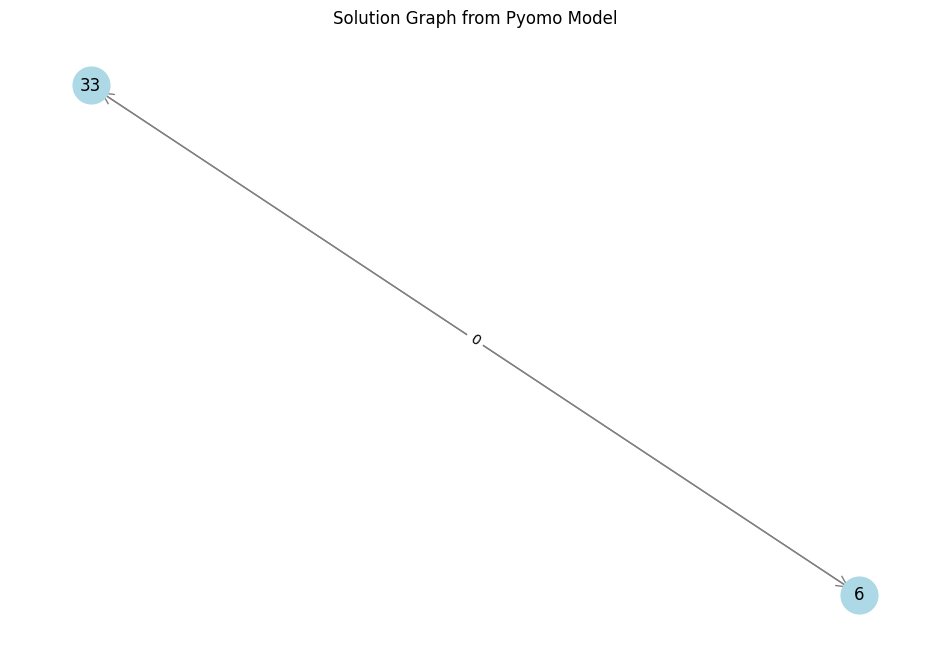

Nodes in the graph: [6, 33]
33
Demand: 18
Capacity: 131.9211396722696


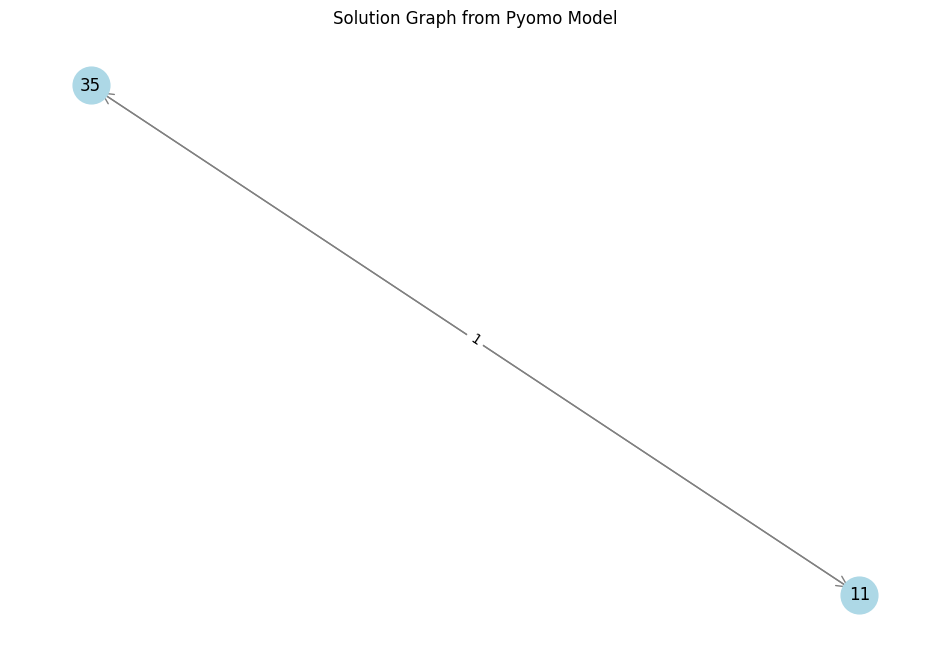

Nodes in the graph: [11, 35]
35
Demand: 11
Capacity: 135.54452491441663


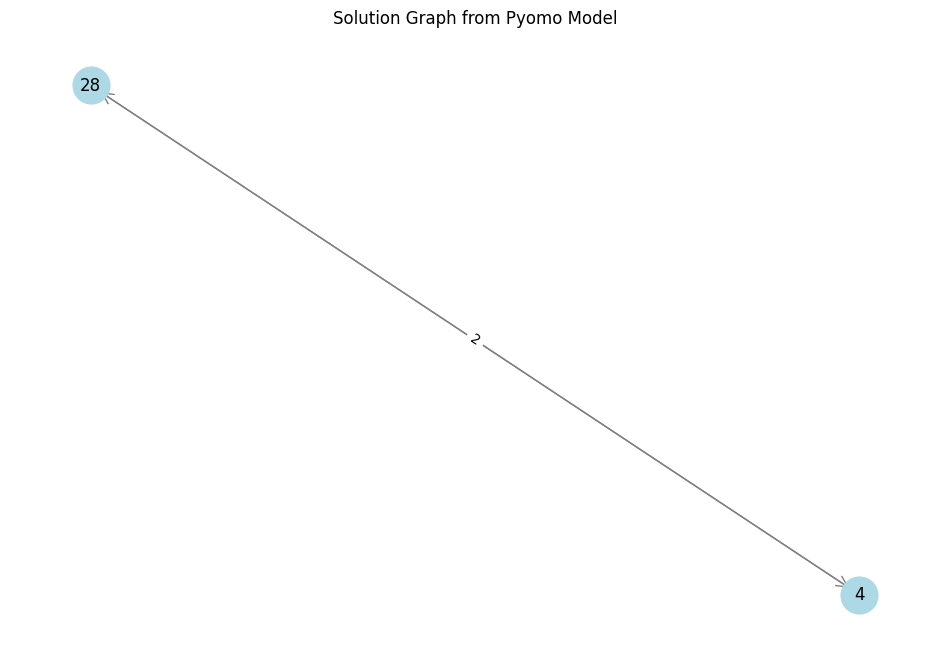

Nodes in the graph: [4, 28]
28
Demand: 25
Capacity: 114.38031900663994


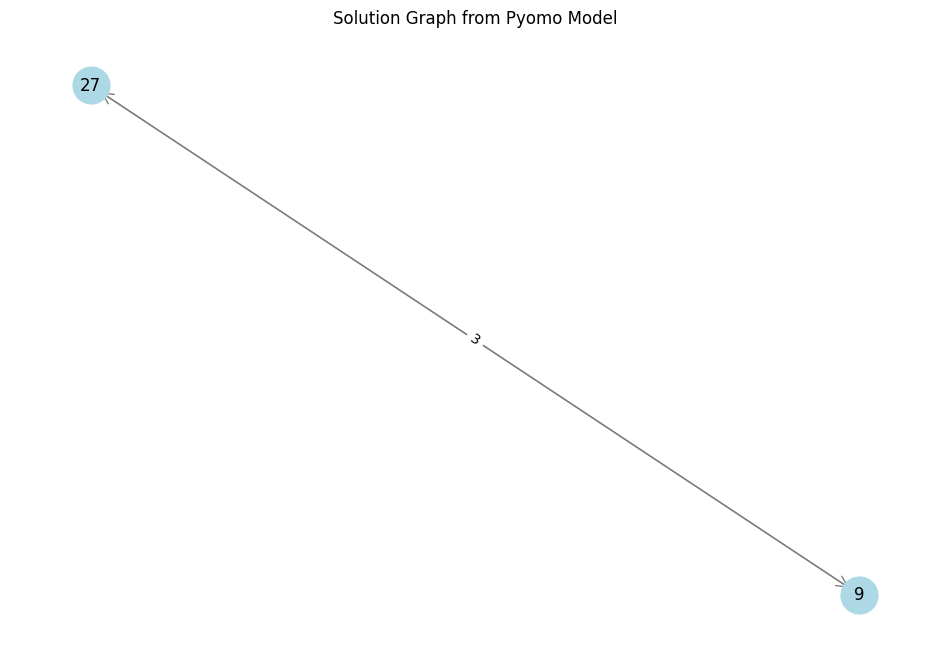

Nodes in the graph: [9, 27]
27
Demand: 10
Capacity: 157.9011075721774


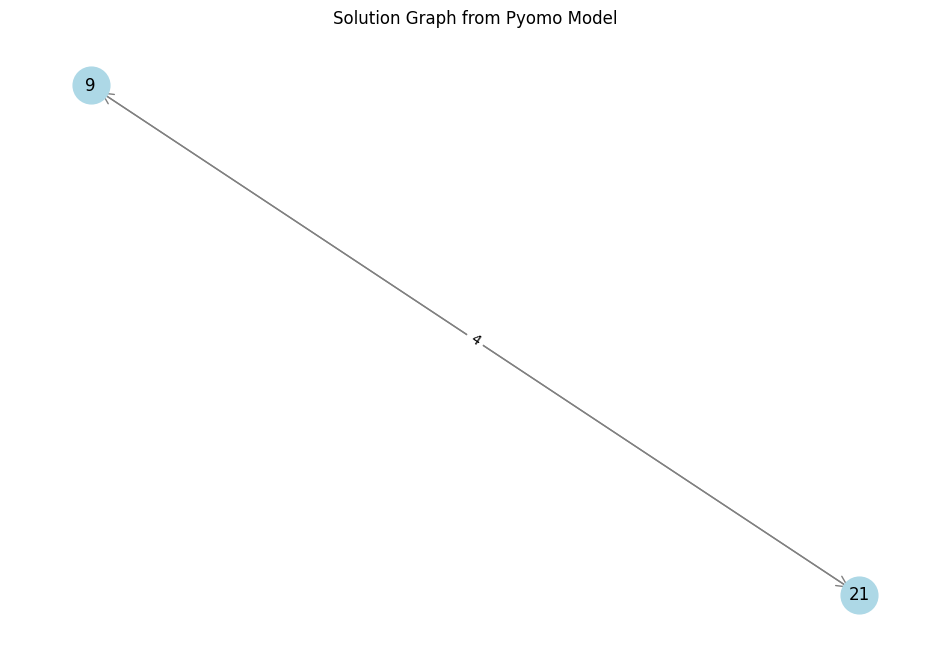

Nodes in the graph: [9, 21]
21
Demand: 15
Capacity: 86.98609179004892


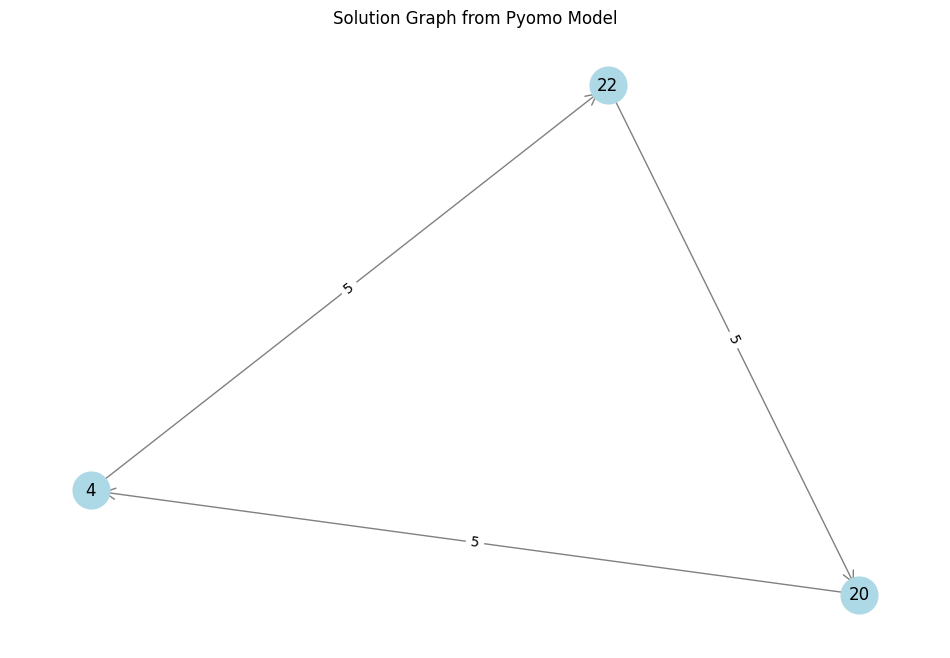

Nodes in the graph: [4, 22, 20]
22
20
Demand: 37
Capacity: 87.10238029800072


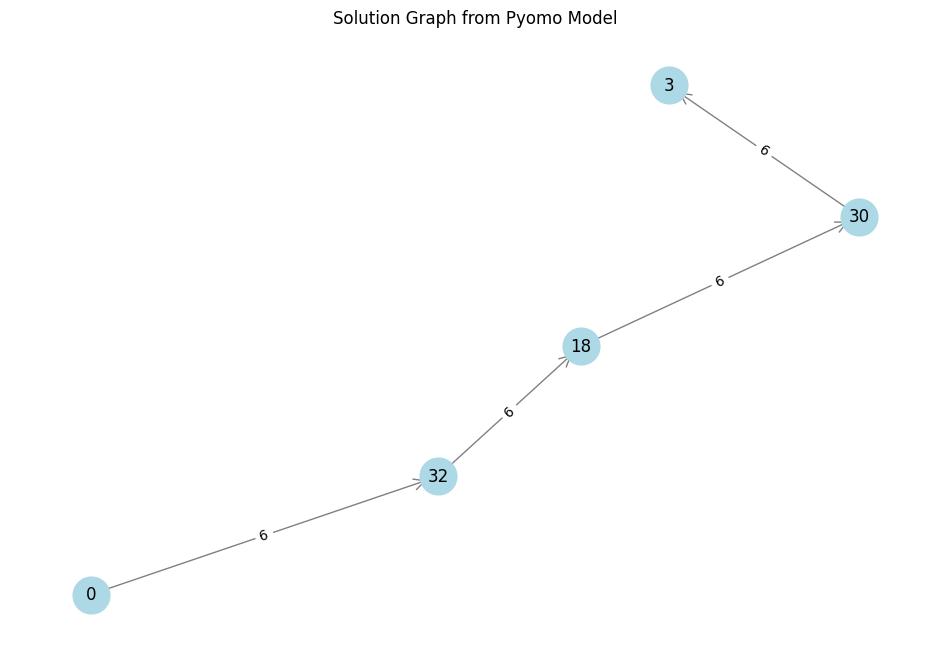

Nodes in the graph: [0, 32, 18, 30, 3]
32
18
30
Demand: 42
Capacity: 100.64567561406786


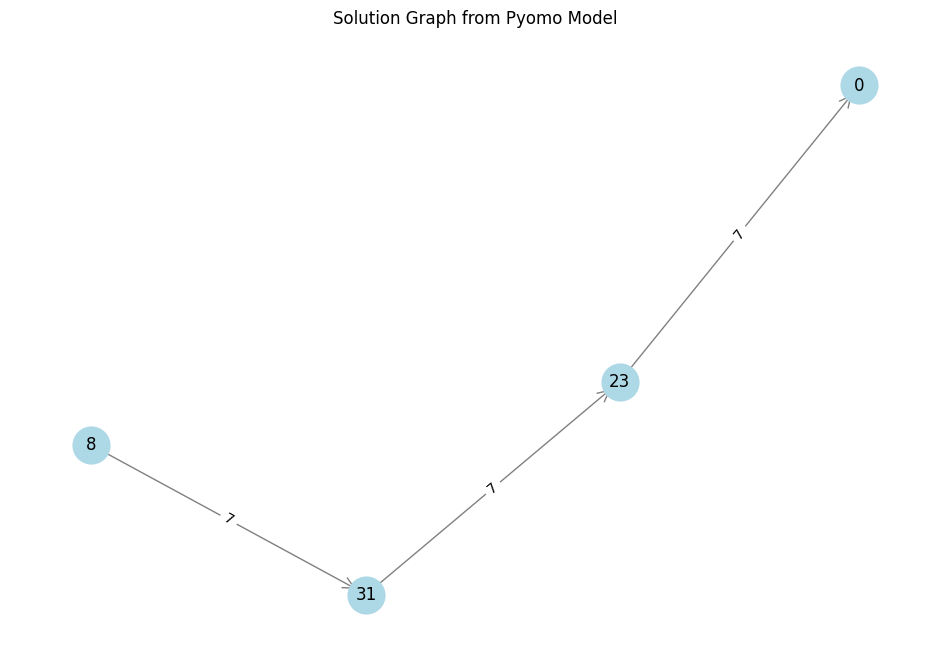

Nodes in the graph: [8, 31, 23, 0]
31
23
Demand: 27
Capacity: 62.88157761574977


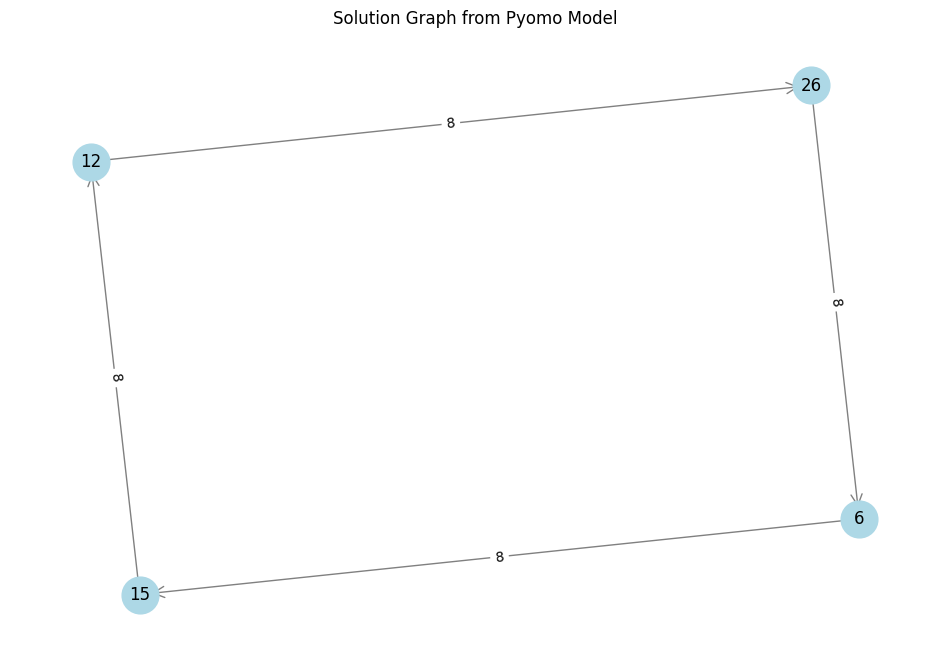

Nodes in the graph: [6, 15, 12, 26]
15
26
Demand: 32
Capacity: 76.55364248957906


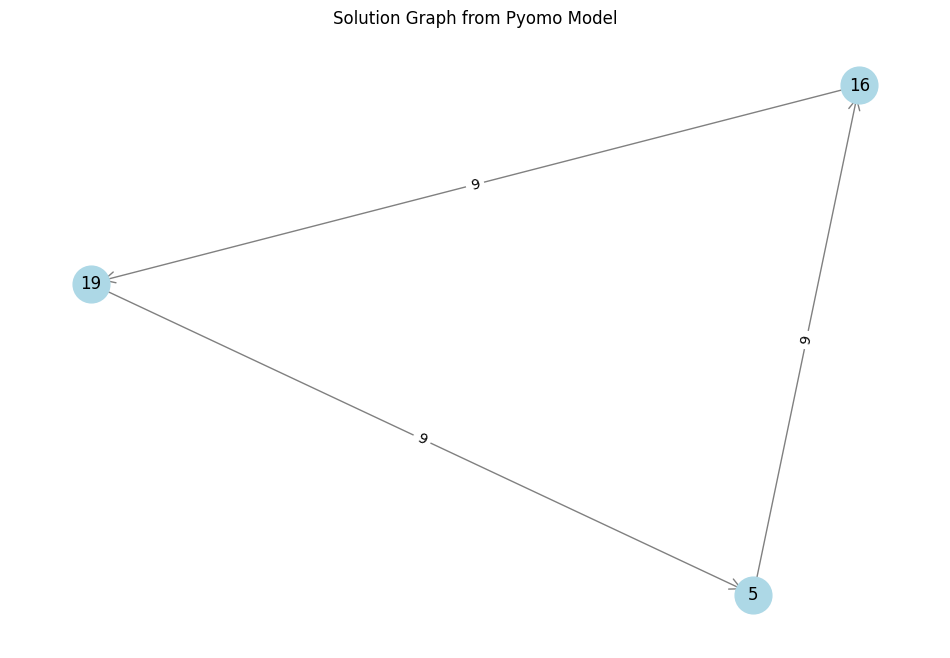

Nodes in the graph: [5, 16, 19]
16
19
Demand: 40
Capacity: 20.459879622393945


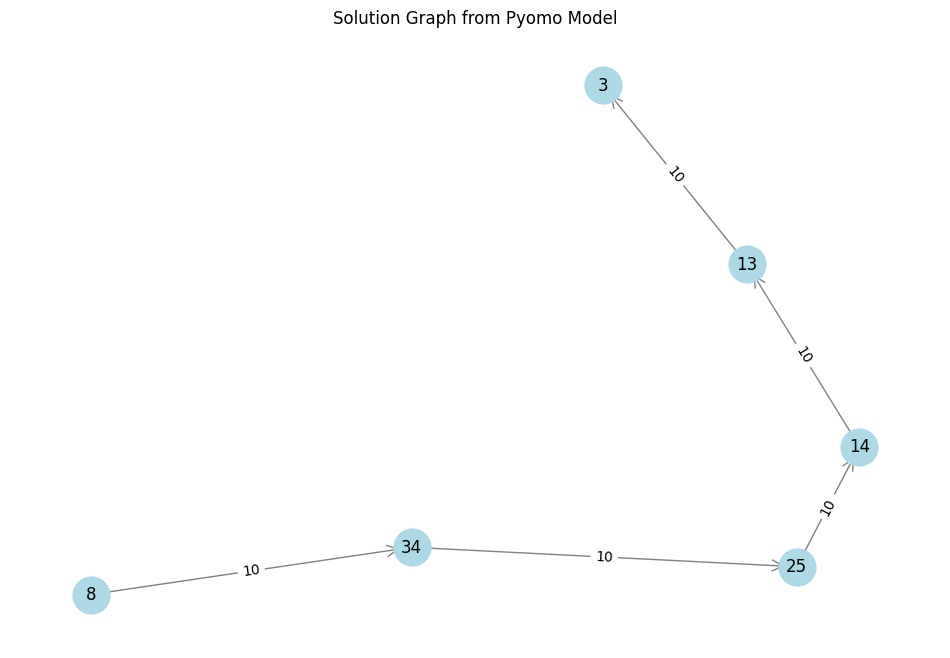

Nodes in the graph: [8, 34, 13, 3, 14, 25]
34
13
14
25
Demand: 57
Capacity: 32.32824384460777


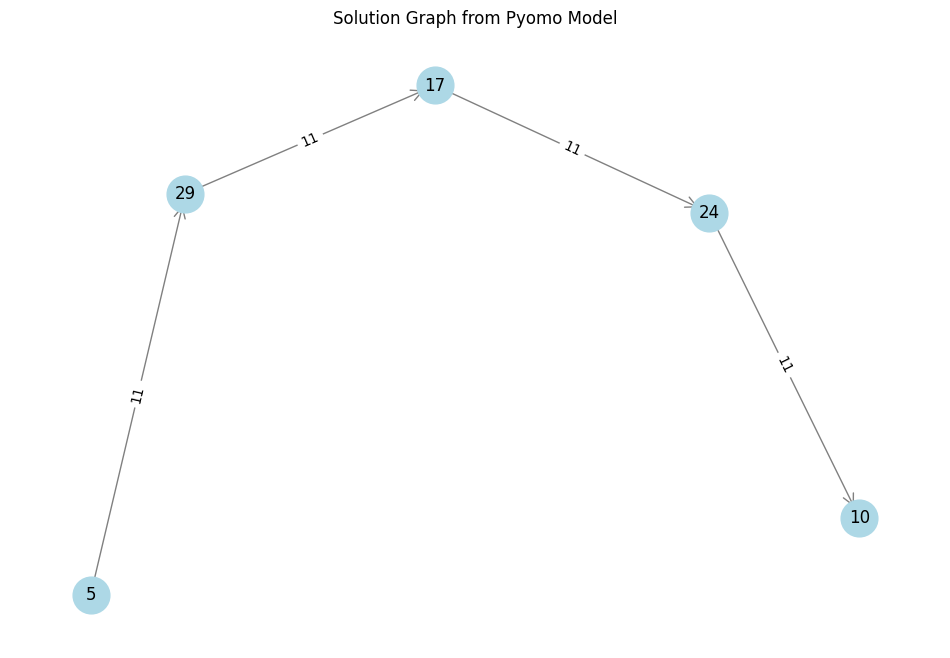

Nodes in the graph: [5, 29, 17, 24, 10]
29
17
24
Demand: 50
Capacity: 25.33764102343962


In [19]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph_from_solution(model, selected_car):
    """
    Creates a directed graph from the Pyomo model solution where x[i, j, k] = 1.
    The graph includes nodes (i, j) and edges with weight k.

    Parameters:
    - model: Solved Pyomo model with decision variable `x`.

    Returns:
    - A NetworkX directed graph representing the solution.
    """
    G = nx.DiGraph()  # Create a directed graph

    # Iterate over all decision variables in the model
    for i in model.nodes:
        for j in model.nodes:

            for k in model.cars_set:
                # Check if the decision variable x[i, j, k] is active and equal to 1
                if round(model.x[i, j, k].value) == 1 and k == selected_car:
                    # Add an edge to the graph
                    G.add_edge(i, j, weight=k)


    return G

def draw_graph(G):
    """
    Draws the graph using NetworkX and Matplotlib.

    Parameters:
    - G: NetworkX graph to be drawn.
    """
    # Use a layout for better visualization
    pos = nx.spring_layout(G, 0.9)  # Positions for all nodes

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, edge_color="gray")
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")

    # Add edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Solution Graph from Pyomo Model")
    plt.axis("off")
    plt.show()

# Usage:
# Assuming `model` is your solved Pyomo model
for i in range(0, len(cars_df)):
    graph = create_graph_from_solution(base_case.model, i)
    draw_graph(graph)
    num_nodes = graph.number_of_nodes()
    nodes_list = list(graph.nodes())
    print("Nodes in the graph:", nodes_list)

    #Now i wanna check if the sum of the demand of the nodes is equal or less than the capacity of the car
    demand = 0
    for j in range(0, len(nodes_list)):
        if nodes_list[j] > first_client:
            print(nodes_list[j])
            demand += clients_df.loc[clients_df['LocationID'] == nodes_list[j], 'Product'].iloc[0]
    print("Demand:", demand)
    print("Capacity:", cars_df["Capacity"].iloc[i])




# Print the list of nodes



# Case 4: Multiple Product Types

In [ ]:
from __future__ import division
from pyomo.environ import *
import pandas  as pd
from pyomo.opt import SolverFactory
import networkx as nx
from matplotlib import pyplot as plt
from amplpy import modules
from pyomo.util.model_size import build_model_size_report

class BaseCase:
    def __init__(self, gas_cars, drones, solar_ev, car_matrix_distance, car_matrix_time, drone_matrix_distance, drone_matrix_time, cars, clients, num_depots, first_client, last_client, num_cars):
        """
        Initialize the model parameters.
        """
        self.gas_cars = gas_cars
        self.drones = drones
        self.solar_ev = solar_ev
        self.car_matrix_distance = car_matrix_distance
        self.car_matrix_time = car_matrix_time
        self.drone_matrix_distance = drone_matrix_distance
        self.drone_matrix_time = drone_matrix_time
        self.cars = cars
        self.clients = clients
        self.num_depots = num_depots
        self.first_client = first_client
        self.last_client = last_client
        self.num_cars = num_cars


        # Create the Pyomo model
        self.model = ConcreteModel()

    def build_model(self):
        """
        Build the optimization model.
        """
        model = self.model

        # Sets
        model.depots_set = RangeSet(0, self.num_depots-1) #Set of depots. In the cost_matrix, the depots come first
        model.clients_set = RangeSet(self.first_client, self.last_client) #Set of clients. In the cost matrix, the clients come after the depots.
        model.nodes = RangeSet(0, self.last_client) #Set of nodes. This includes both depots and clients.
        model.cars_set = RangeSet(0, self.num_cars-1) #Set of vehicles.


        #Decision Variables
        model.x = Var(model.nodes, model.nodes, model.cars_set, domain=Binary)
        model.u = Var(model.clients_set, model.cars_set, domain=NonNegativeReals, bounds = (0, len(model.nodes)-1))




        # Objective: Minimize total cost (energy, installation, and communication costs)
        def obj_expression(model):
            cost1 = 0
            for k in model.cars_set:
                cost1 += sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set)*500
            #Revised with JD

            #Cost of driving the car (distance)
            cost2 = 0
            for i in model.nodes:
                for j in model.nodes:
                    for k in model.cars_set:
                        if self.cars['VehicleType'].iloc[k] == "Gas Car":
                            cost2 += self.car_matrix_distance[i][j]*model.x[i,j,k]*self.gas_cars["Freight Rate [COP/km]"]
                        elif self.cars["VehicleType"].iloc[k] == "drone":
                            cost2 += self.drone_matrix_distance[i][j]*model.x[i,j,k]*self.drones["Freight Rate [COP/km]"]
                        elif self.cars["VehicleType"].iloc[k] == "EV":
                            cost2 += self.car_matrix_distance[i][j]*model.x[i,j,k]*self.solar_ev["Freight Rate [COP/km]"]
            #Revised with JD

            #Cost of driving the car (time)
            cost3 = 0
            for i in model.nodes:
                for j in model.nodes:
                    for k in model.cars_set:
                        if self.cars["VehicleType"].iloc[k] == "Gas Car":
                            cost3 += self.car_matrix_time[i][j]*model.x[i,j,k]*self.gas_cars["Time Rate [COP/min]"]
                        elif self.cars["VehicleType"].iloc[k] == "drone":
                            cost3 += self.drone_matrix_time[i][j]*model.x[i,j,k]*self.drones["Time Rate [COP/min]"]
                        elif self.cars["VehicleType"].iloc[k] == "EV":
                            cost3 += self.car_matrix_time[i][j]*model.x[i,j,k]*self.solar_ev["Time Rate [COP/min]"]
            #Revised with JD

            #Cost for gas
            cost4 = 0
            for k in model.cars_set:
                if self.cars["VehicleType"].iloc[k] == "Gas Car":
                    cost4 += self.gas_cars["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(self.car_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes) / self.gas_cars["Gas Efficiency [km/gal]"])
                elif self.cars["VehicleType"].iloc[k] == "drone":
                    cost4 += self.drones["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(self.drone_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes) / self.drones["Electricity Efficency [kWh/km]"])
                elif self.cars["VehicleType"].iloc[k] == "EV":
                    cost4 += 0
            #Revised with JD

            #Cost for maintenance
            cost5 = 0
            '''for k in model.cars_set:
                if self.cars["VehicleType"].iloc[k] == "Gas Car":
                    cost5 += self.gas_cars["Daily Maintenance [COP/day]"]
                elif self.cars["VehicleType"].iloc[k] == "drone":
                    cost5 += self.drones["Daily Maintenance [COP/day]"]
                elif self.cars["VehicleType"].iloc[k] == "EV":
                    cost5 += self.solar_ev["Daily Maintenance [COP/day]"]'''
            #Revised with JD, he propose to use it as a constant

            return cost1 + cost2 + cost3 + cost4 + cost5

        model.obj = Objective(rule=obj_expression, sense=minimize)

        #Constraint 1: Vehicle Flow Conservation: Ensure that each vehicle entering a node also leaves the node if the node is a client:
        def restriccion_1(model, j, k):
                return sum(model.x[i,j,k] for i in model.nodes) - sum(model.x[j,i,k] for i in model.nodes) == 0
        model.restriccion_1 = Constraint(model.clients_set, model.cars_set, rule = restriccion_1)



        def restriccion_2(model, j):
            return sum(model.x[i,j,k] for i in model.nodes for k in model.cars_set) == 1
        model.restriccion_2 = Constraint(model.clients_set,  rule = restriccion_2)

        #Constraint 3_1: Vehicles end in any depot
        def restriccion_3_1(model, k):
            return sum(model.x[i,j,k] for j in model.depots_set for i in model.nodes) == 1
        model.restriccion_3_1 = Constraint(model.cars_set, rule = restriccion_3_1)

        #Constraint 3_2: Vehicles start in any depot
        def restriccion_3_2(model, k):
            return sum(model.x[i,j,k] for i in model.depots_set for j in model.nodes) == 1
        model.restriccion_3_2 = Constraint(model.cars_set, rule = restriccion_3_2)

        def restriccion_5(model, i, j, k):
            if i != j:
                return model.u[i,k] - model.u[j,k] + len(model.clients_set)*model.x[i,j,k] <= len(model.clients_set)-1
            else:
                return Constraint.Skip
        model.restriccion_5 = Constraint(model.clients_set, model.clients_set, model.cars_set, rule = restriccion_5)




        #Constraint 4: Vehicle capacity must be bigger than the demand of the clients
        def restriccion_4(model, k):
            return sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set) <= self.cars["Capacity"].iloc[k]
        model.restriccion_4 = Constraint(model.cars_set, rule = restriccion_4)



        #Constraint 6: Each car should have enough range to visit all the clients
        def restriccion_6(model, k):
            if self.cars["VehicleType"].iloc[k] == "EV" or self.cars["VehicleType"].iloc[k] == "Gas Car":
                return self.cars["Range"].iloc[k] >= sum(self.car_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes)
            elif self.cars["VehicleType"].iloc[k] == "drone":
                return self.cars["Range"][k] >= sum(self.drone_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes)
        model.restriccion_6 = Constraint(model.cars_set, rule = restriccion_6)

        #Cannot travel from depot to depot directly
        def restriccion_7(model, i, j, k):
            return model.x[i,j,k] == 0
        model.restriccion_7 = Constraint(model.depots_set, model.depots_set, model.cars_set, rule = restriccion_7)





        return model

    def solve_model(self):
        solver_name = "highs"
        solver = SolverFactory(solver_name+"nl", executable=modules.find(solver_name), solve_io="nl")
        #solver.options['parallel'] = 'on'
        solver.options['time_limit'] = 3600  # 1-hour time limit
        #solver.options['presolve'] = 'on'
        #solver.options['mip_rel_gap'] = 0.01  # 1% relative gap
        #solver.options['simplex_strategy'] = 1  # Dual simplex
        #solver.options['simplex_max_concurrency'] = 8  # Max concurrency
        #solver.options['mip_min_logging_interval'] = 10  # Log every 10 seconds
        #solver.options['mip_heuristic_effort'] = 0.2  # Increase heuristic effort

        result = solver.solve(self.model, tee=True)

        # Check solver status
        if result.solver.termination_condition == TerminationCondition.optimal:
            print("Optimal solution found.")
        elif result.solver.termination_condition == TerminationCondition.maxTimeLimit:
            print("Time limit reached, solution may be suboptimal.")
        else:
            print(f"Solver terminated with condition: {result.solver.termination_condition}")

        print(result)
        """
        Solve the model using the given solver.
        """
        return result

    def display_results(self):
        """
        Display the results of the optimization.
        """
        self.model.display()
    def print_output(self):
        """
        Plot sensor placement solutions on directed graphs using NetworkX for each sensor type in a subplot.
        """
        pass

base_case = BaseCase(gas_cars, drones, solar_ev, car_matrix_distance, car_matrix_time, drone_matrix_distance, drone_matrix_time, cars_df, clients_df, num_depots, first_client, last_client, num_cars)

base_case.build_model()

base_case.solve_model()

# Caso 3


In [6]:
import pandas as pd
import numpy as np
import requests

# Data for Gas Cars
gas_cars = {
    "Vehicle": "Gas Car",
    "Freight Rate [COP/km]": 5000,
    "Time Rate [COP/min]": 500,
    "Daily Maintenance [COP/day]": 30000,
    "Recharge/Fuel Cost [COP/(gal or kWh)]": 16000,
    "Recharge/Fuel Time [min/10 percent charge]": 0.1,
    "Avg. Speed [km/h]": None,
    "Gas Efficiency [km/gal]": 10,
}

# Data for Drones
drones = {
    "Vehicle": "Drone",
    "Freight Rate [COP/km]": 500,
    "Time Rate [COP/min]": 500,
    "Daily Maintenance [COP/day]": 3000,
    "Recharge/Fuel Cost [COP/(gal or kWh)]": 220.73,
    "Recharge/Fuel Time [min/10 percent charge]": 2,
    "Avg. Speed [km/h]": 40,
    "Gas Efficiency [km/gal]": None,
    "Electricity Efficency [kWh/km]": 0.15,
}


# Data for Solar EVs
solar_ev = {
    "Vehicle": "Solar EV",
    "Freight Rate [COP/km]": 4000,
    "Time Rate [COP/min]": 500,
    "Daily Maintenance [COP/day]": 21000,
    "Recharge/Fuel Cost [COP/(gal or kWh)]": None,
    "Recharge/Fuel Time [min/10 percent charge]": None,
    "Avg. Speed [km/h]": None,
    "Gas Efficiency [km/gal]": None,
    "Electricity Efficency [kWh/km]": 0.15,
}



In [7]:
import math

import pandas as pd
depots_df = pd.read_csv('Depots.csv')
clients_df = pd.read_csv('Clients.csv')
depots_capacity_df = pd.read_csv('DepotCapacities.csv')

depots_df = depots_df.merge(depots_capacity_df[['DepotID', 'Product']], on='DepotID', how='left')


#depots_df = pd.read_csv('smalldepots.csv')
#clients_df = pd.read_csv('smallclients.csv')

# extract coordinates
depots_coords = depots_df[['Longitude', 'Latitude']].values.tolist()
clients_coords = clients_df[['Longitude', 'Latitude']].values.tolist()

# Combine depots and clients
all_coords = depots_coords + clients_coords

# Build the coordinates string for OSRM
coords_str = ';'.join([f"{lon},{lat}" for lon, lat in all_coords])




# API URL
url = f"https://router.project-osrm.org/table/v1/driving/{coords_str}"

# Parameters
params = {
    'sources': ';'.join(map(str, range(len(all_coords)))),
    'destinations': ';'.join(map(str, range(len(all_coords)))),
    'annotations': 'duration,distance'
}

# Send the request
response = requests.get(url, params=params)

# Check for successful response
if response.status_code != 200:
    print(f"Error: {response.status_code}")
    print(response.text)
    exit()

data = response.json()

# Extract the distance matrix
car_matrix_distance = np.array(data['distances'])
car_matrix_distance = car_matrix_distance / 1000

#The distance matrix gives the distance in km from node i to node j.

# Extract the duration matrix
car_matrix_time = np.array(data['durations'])
car_matrix_time = car_matrix_time / 60

#The duration matrix gives the time in minutes from node i to node j.




def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

nodes = all_coords

drone_matrix = [[0 for _ in range(len(nodes))] for _ in range(len(nodes))]
#The drone matrix gives the distance in km from node i to node j if a drone is used.

for i in range(len(nodes)):
    for j in range(len(nodes)):
        if i != j:
            origin = nodes[i]
            destination = nodes[j]
            origin_latitud = origin[1]
            origin_longitud = origin[0]
            destination_latitud = destination[1]
            destination_longitud = destination[0]
            drone_matrix[i][j] = haversine(origin_longitud, origin_latitud, destination_longitud, destination_latitud)

drone_matrix_distance = np.array(drone_matrix)

drone_matrix_time = drone_matrix_distance / drones["Avg. Speed [km/h]"]
drone_matrix_time = drone_matrix_time * 60

#No cars anc clients no more. We gonna use dataframes


cars_df = pd.read_csv("Vehicles.csv")

num_depots = len(depots_coords)

depots_df["LocationID"] = depots_df["LocationID"] - 1
clients_df["LocationID"] = clients_df["LocationID"] - 1

first_client = clients_df["LocationID"].iloc[0]
last_client = clients_df["LocationID"].iloc[-1]



np.fill_diagonal(car_matrix_distance, 9999999)
np.fill_diagonal(car_matrix_time, 9999999)
np.fill_diagonal(drone_matrix_distance, 9999999)
np.fill_diagonal(drone_matrix_time, 9999999)




num_cars = len(cars_df)


print(depots_df)
print(clients_df)





    DepotID  LocationID  Longitude  Latitude  Product
0         1           0 -74.081242  4.750212        8
1         2           1 -74.109934  4.536383       10
2         3           2 -74.038548  4.792926        0
3         4           3 -74.067069  4.721678        4
4         5           4 -74.138263  4.607707       28
5         6           5 -74.124002  4.650463        3
6         7           6 -74.095619  4.621912        0
7         8           7 -74.109756  4.678961       10
8         9           8 -74.095472  4.735973       43
9        10           9 -74.109916  4.550641        1
10       11          10 -74.109774  4.664703       16
11       12          11 -74.124089  4.579174       18
   ClientID  LocationID  Product  Longitude  Latitude
0         1          12       12 -74.196992  4.632553
1         2          13       15 -74.155037  4.601328
2         3          14       15 -74.101787  4.732421
3         4          15        6 -74.194862  4.638612
4         5          16     

In [10]:
from __future__ import division
from pyomo.environ import *
import pandas  as pd
from pyomo.opt import SolverFactory
import networkx as nx
from matplotlib import pyplot as plt
#from amplpy import modules
from pyomo.util.model_size import build_model_size_report

class BaseCase:
    def __init__(self, gas_cars, drones, solar_ev, car_matrix_distance, car_matrix_time, drone_matrix_distance, drone_matrix_time, cars, clients, num_depots, first_client, last_client, num_cars):
        """
        Initialize the model parameters.
        """
        self.gas_cars = gas_cars
        self.drones = drones
        self.solar_ev = solar_ev
        self.car_matrix_distance = car_matrix_distance
        self.car_matrix_time = car_matrix_time
        self.drone_matrix_distance = drone_matrix_distance
        self.drone_matrix_time = drone_matrix_time
        self.cars = cars
        self.clients = clients
        self.num_depots = num_depots
        self.first_client = first_client
        self.last_client = last_client
        self.num_cars = num_cars


        # Create the Pyomo model
        self.model = ConcreteModel()

    def build_model(self):
        """
        Build the optimization model.
        """
        model = self.model

        # Sets
        model.depots_set = RangeSet(0, self.num_depots-1) #Set of depots. In the cost_matrix, the depots come first
        model.clients_set = RangeSet(self.first_client, self.last_client) #Set of clients. In the cost matrix, the clients come after the depots.
        model.nodes = RangeSet(0, self.last_client) #Set of nodes. This includes both depots and clients.
        model.cars_set = RangeSet(0, self.num_cars-1) #Set of vehicles.


        #Decision Variables
        model.x = Var(model.nodes, model.nodes, model.cars_set, domain=Binary)
        model.u = Var(model.clients_set, model.cars_set, domain=NonNegativeReals, bounds = (0, len(model.nodes)-1))




        # Objective: Minimize total cost (energy, installation, and communication costs)
        def obj_expression(model):
            cost1 = 0
            for k in model.cars_set:
                cost1 += sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set)*500
            #Revised with JD

            #Cost of driving the car (distance)
            cost2 = 0
            for i in model.nodes:
                for j in model.nodes:
                    for k in model.cars_set:
                        if self.cars['VehicleType'].iloc[k] == "Gas Car":
                            cost2 += self.car_matrix_distance[i][j]*model.x[i,j,k]*self.gas_cars["Freight Rate [COP/km]"]
                        elif self.cars["VehicleType"].iloc[k] == "drone":
                            cost2 += self.drone_matrix_distance[i][j]*model.x[i,j,k]*self.drones["Freight Rate [COP/km]"]
                        elif self.cars["VehicleType"].iloc[k] == "EV":
                            cost2 += self.car_matrix_distance[i][j]*model.x[i,j,k]*self.solar_ev["Freight Rate [COP/km]"]
            #Revised with JD

            #Cost of driving the car (time)
            cost3 = 0
            for i in model.nodes:
                for j in model.nodes:
                    for k in model.cars_set:
                        if self.cars["VehicleType"].iloc[k] == "Gas Car":
                            cost3 += self.car_matrix_time[i][j]*model.x[i,j,k]*self.gas_cars["Time Rate [COP/min]"]
                        elif self.cars["VehicleType"].iloc[k] == "drone":
                            cost3 += self.drone_matrix_time[i][j]*model.x[i,j,k]*self.drones["Time Rate [COP/min]"]
                        elif self.cars["VehicleType"].iloc[k] == "EV":
                            cost3 += self.car_matrix_time[i][j]*model.x[i,j,k]*self.solar_ev["Time Rate [COP/min]"]
            #Revised with JD

            #Cost for gas
            cost4 = 0
            for k in model.cars_set:
                if self.cars["VehicleType"].iloc[k] == "Gas Car":
                    cost4 += self.gas_cars["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(self.car_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes) / self.gas_cars["Gas Efficiency [km/gal]"])
                elif self.cars["VehicleType"].iloc[k] == "drone":
                    cost4 += self.drones["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(self.drone_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes) / self.drones["Electricity Efficency [kWh/km]"])
                elif self.cars["VehicleType"].iloc[k] == "EV":
                    cost4 += 0
            #Revised with JD

            #Cost for maintenance
            cost5 = 0
            '''for k in model.cars_set:
                if self.cars["VehicleType"].iloc[k] == "Gas Car":
                    cost5 += self.gas_cars["Daily Maintenance [COP/day]"]
                elif self.cars["VehicleType"].iloc[k] == "drone":
                    cost5 += self.drones["Daily Maintenance [COP/day]"]
                elif self.cars["VehicleType"].iloc[k] == "EV":
                    cost5 += self.solar_ev["Daily Maintenance [COP/day]"]'''
            #Revised with JD, he propose to use it as a constant

            return cost1 + cost2 + cost3 + cost4 + cost5

        model.obj = Objective(rule=obj_expression, sense=minimize)

        #Constraint 1: Vehicle Flow Conservation: Ensure that each vehicle entering a node also leaves the node if the node is a client:
        def restriccion_1(model, j, k):
                return sum(model.x[i,j,k] for i in model.nodes) - sum(model.x[j,i,k] for i in model.nodes) == 0
        model.restriccion_1 = Constraint(model.clients_set, model.cars_set, rule = restriccion_1)



        def restriccion_2(model, j):
            return sum(model.x[i,j,k] for i in model.nodes for k in model.cars_set) == 1
        model.restriccion_2 = Constraint(model.clients_set,  rule = restriccion_2)

        #Constraint 3_1: Vehicles end in any depot
        def restriccion_3_1(model, k):
            return sum(model.x[i,j,k] for j in model.depots_set for i in model.nodes) == 1
        model.restriccion_3_1 = Constraint(model.cars_set, rule = restriccion_3_1)

        #Constraint 3_2: Vehicles start in any depot
        def restriccion_3_2(model, k):
            return sum(model.x[i,j,k] for i in model.depots_set for j in model.nodes) == 1
        model.restriccion_3_2 = Constraint(model.cars_set, rule = restriccion_3_2)

        def restriccion_5(model, i, j, k):
            if i != j:
                return model.u[i,k] - model.u[j,k] + len(model.clients_set)*model.x[i,j,k] <= len(model.clients_set)-1
            else:
                return Constraint.Skip
        model.restriccion_5 = Constraint(model.clients_set, model.clients_set, model.cars_set, rule = restriccion_5)




        #Constraint 4: Vehicle capacity must be bigger than the demand of the clients
        def restriccion_4(model, k):
            return sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set) <= self.cars["Capacity"].iloc[k]
        model.restriccion_4 = Constraint(model.cars_set, rule = restriccion_4)



        #Constraint 6: Each car should have enough range to visit all the clients
        def restriccion_6(model, k):
            if self.cars["VehicleType"].iloc[k] == "EV" or self.cars["VehicleType"].iloc[k] == "Gas Car":
                return self.cars["Range"].iloc[k] >= sum(self.car_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes)
            elif self.cars["VehicleType"].iloc[k] == "drone":
                return self.cars["Range"][k] >= sum(self.drone_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes)
        model.restriccion_6 = Constraint(model.cars_set, rule = restriccion_6)

        #Cannot travel from depot to depot directly
        def restriccion_7(model, i, j, k):
            return model.x[i,j,k] == 0
        model.restriccion_7 = Constraint(model.depots_set, model.depots_set, model.cars_set, rule = restriccion_7)

        #Capacity of the depot must not exceed the load of the cars that get out of it. 
        def restriccion_8(model, b):
            return sum(sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set) * model.x[a,b,k] for a in model.depots_set for k in model.cars_set )<= depots_df.loc[depots_df['LocationID'] == b, 'Product'].iloc[0]
        model.restriccion_8 = Constraint(model.depots_set, rule = restriccion_8)





        return model

    def solve_model(self):
        #solver_name = "highs"
        solver = SolverFactory('ipopt')
        #solver.options['parallel'] = 'on'
        solver.options['time_limit'] = 3600  # 1-hour time limit
        #solver.options['presolve'] = 'on'
        #solver.options['mip_rel_gap'] = 0.01  # 1% relative gap
        #solver.options['simplex_strategy'] = 1  # Dual simplex
        #solver.options['simplex_max_concurrency'] = 8  # Max concurrency
        #solver.options['mip_min_logging_interval'] = 10  # Log every 10 seconds
        #solver.options['mip_heuristic_effort'] = 0.2  # Increase heuristic effort

        result = solver.solve(self.model, tee=True)

        # Check solver status
        if result.solver.termination_condition == TerminationCondition.optimal:
            print("Optimal solution found.")
        elif result.solver.termination_condition == TerminationCondition.maxTimeLimit:
            print("Time limit reached, solution may be suboptimal.")
        else:
            print(f"Solver terminated with condition: {result.solver.termination_condition}")

        print(result)
        """
        Solve the model using the given solver.
        """
        return result

    def display_results(self):
        """
        Display the results of the optimization.
        """
        self.model.display()
    def print_output(self):
        """
        Plot sensor placement solutions on directed graphs using NetworkX for each sensor type in a subplot.
        """
        pass

base_case = BaseCase(gas_cars, drones, solar_ev, car_matrix_distance, car_matrix_time, drone_matrix_distance, drone_matrix_time, cars_df, clients_df, num_depots, first_client, last_client, num_cars)

base_case.build_model()

base_case.solve_model()

ipopt


ApplicationError: No executable found for solver 'ipopt'

In [11]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph (example data)
G.add_edges_from([
    (1, 2), 
    (2, 3), 
    (3, 4),
    (4, 5)
])

# Find the path from a start node to an end node
start_node = 1
end_node = 5

# Use NetworkX's shortest_path function to get the path
path = nx.shortest_path(G, source=start_node, target=end_node)

# Display the nodes in the order of the path
print("Nodes in the order of the path:", path)


Nodes in the order of the path: [1, 2, 3, 4, 5]


In [ ]:
def restriccion_10(model,p):
    return(
        sum(
            sum(
                sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes)
                for j in model.clients_set 
            )
            * sum(model.x[p,i,k] for i in model.clients)
            for k in model.cars_set
        ) <= depots_df.loc[depots_df['LocationID'] == p, 'Product'].iloc[0]
    )

# Attempt of single class :))

In [ ]:
from __future__ import division
from pyomo.environ import *
import pandas  as pd
from pyomo.opt import SolverFactory
import networkx as nx
from matplotlib import pyplot as plt
from amplpy import modules
from pyomo.util.model_size import build_model_size_report
import math
import pandas as pd
import numpy as np
import requests

class BaseCase:
    #Here's the logic: I'll do the same as before, but all inside the class itself. 
    def __init__(self, path_to_clients, path_to_vechicles, path_to_depots, path_to_depots_capacity, case_selection):
        """
        Initialize the model parameters.
        """
        self.gas_cars = {
            "Vehicle": "Gas Car",
            "Freight Rate [COP/km]": 5000,
            "Time Rate [COP/min]": 500,
            "Daily Maintenance [COP/day]": 30000,
            "Recharge/Fuel Cost [COP/(gal or kWh)]": 16000,
            "Recharge/Fuel Time [min/10 percent charge]": 0.1,
            "Avg. Speed [km/h]": None,
            "Gas Efficiency [km/gal]": 10,
        }

        self.drones = {
            "Vehicle": "Drone",
            "Freight Rate [COP/km]": 500,
            "Time Rate [COP/min]": 500,
            "Daily Maintenance [COP/day]": 3000,
            "Recharge/Fuel Cost [COP/(gal or kWh)]": 220.73,
            "Recharge/Fuel Time [min/10 percent charge]": 2,
            "Avg. Speed [km/h]": 40,
            "Gas Efficiency [km/gal]": None,
            "Electricity Efficency [kWh/km]": 0.15,
        }

        self.solar_ev = {
            "Vehicle": "Solar EV",
            "Freight Rate [COP/km]": 4000,
            "Time Rate [COP/min]": 500,
            "Daily Maintenance [COP/day]": 21000,
            "Recharge/Fuel Cost [COP/(gal or kWh)]": None,
            "Recharge/Fuel Time [min/10 percent charge]": None,
            "Avg. Speed [km/h]": None,
            "Gas Efficiency [km/gal]": None,
            "Electricity Efficency [kWh/km]": 0.15,
        }
        self.car_matrix_distance = car_matrix_distance
        self.car_matrix_time = car_matrix_time
        self.drone_matrix_distance = drone_matrix_distance
        self.drone_matrix_time = drone_matrix_time
        self.cars = cars
        self.clients = clients
        self.num_depots = num_depots
        self.first_client = first_client
        self.last_client = last_client
        self.num_cars = num_cars


        # Create the Pyomo model
        self.model = ConcreteModel()

    def build_model(self):
        """
        Build the optimization model.
        """
        model = self.model

        # Sets
        model.depots_set = RangeSet(0, self.num_depots-1) #Set of depots. In the cost_matrix, the depots come first
        model.clients_set = RangeSet(self.first_client, self.last_client) #Set of clients. In the cost matrix, the clients come after the depots.
        model.nodes = RangeSet(0, self.last_client) #Set of nodes. This includes both depots and clients.
        model.cars_set = RangeSet(0, self.num_cars-1) #Set of vehicles.


        #Decision Variables
        model.x = Var(model.nodes, model.nodes, model.cars_set, domain=Binary)
        model.u = Var(model.clients_set, model.cars_set, domain=NonNegativeReals, bounds = (0, len(model.nodes)-1))




        # Objective: Minimize total cost (energy, installation, and communication costs)
        def obj_expression(model):
            cost1 = 0
            for k in model.cars_set:
                cost1 += sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set)*500/2
            #Revised with JD

            #Cost of driving the car (distance)
            cost2 = 0
            for i in model.nodes:
                for j in model.nodes:
                    for k in model.cars_set:
                        if self.cars['VehicleType'].iloc[k] == "Gas Car":
                            cost2 += self.car_matrix_distance[i][j]*model.x[i,j,k]*self.gas_cars["Freight Rate [COP/km]"]
                        elif self.cars["VehicleType"].iloc[k] == "drone":
                            cost2 += self.drone_matrix_distance[i][j]*model.x[i,j,k]*self.drones["Freight Rate [COP/km]"]
                        elif self.cars["VehicleType"].iloc[k] == "EV":
                            cost2 += self.car_matrix_distance[i][j]*model.x[i,j,k]*self.solar_ev["Freight Rate [COP/km]"]
            #Revised with JD

            #Cost of driving the car (time)
            cost3 = 0
            for i in model.nodes:
                for j in model.nodes:
                    for k in model.cars_set:
                        if self.cars["VehicleType"].iloc[k] == "Gas Car":
                            cost3 += self.car_matrix_time[i][j]*model.x[i,j,k]*self.gas_cars["Time Rate [COP/min]"]
                        elif self.cars["VehicleType"].iloc[k] == "drone":
                            cost3 += self.drone_matrix_time[i][j]*model.x[i,j,k]*self.drones["Time Rate [COP/min]"]
                        elif self.cars["VehicleType"].iloc[k] == "EV":
                            cost3 += self.car_matrix_time[i][j]*model.x[i,j,k]*self.solar_ev["Time Rate [COP/min]"]
            #Revised with JD

            #Cost for gas
            cost4 = 0
            for k in model.cars_set:
                if self.cars["VehicleType"].iloc[k] == "Gas Car":
                    cost4 += self.gas_cars["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(self.car_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes) / self.gas_cars["Gas Efficiency [km/gal]"])
                elif self.cars["VehicleType"].iloc[k] == "drone":
                    cost4 += self.drones["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(self.drone_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes) / self.drones["Electricity Efficency [kWh/km]"])
                elif self.cars["VehicleType"].iloc[k] == "EV":
                    cost4 += 0
            #Revised with JD

            #Cost for maintenance
            cost5 = 0
            '''for k in model.cars_set:
                if self.cars["VehicleType"].iloc[k] == "Gas Car":
                    cost5 += self.gas_cars["Daily Maintenance [COP/day]"]
                elif self.cars["VehicleType"].iloc[k] == "drone":
                    cost5 += self.drones["Daily Maintenance [COP/day]"]
                elif self.cars["VehicleType"].iloc[k] == "EV":
                    cost5 += self.solar_ev["Daily Maintenance [COP/day]"]'''
            #Revised with JD, he propose to use it as a constant

            return cost1 + cost2 + cost3 + cost4 + cost5

        model.obj = Objective(rule=obj_expression, sense=minimize)

        #Constraint 1: Vehicle Flow Conservation: Ensure that each vehicle entering a node also leaves the node if the node is a client:
        def restriccion_1(model, j, k):
                return sum(model.x[i,j,k] for i in model.nodes) - sum(model.x[j,i,k] for i in model.nodes) == 0
        model.restriccion_1 = Constraint(model.clients_set, model.cars_set, rule = restriccion_1)



        def restriccion_2(model, j):
            return sum(model.x[i,j,k] for i in model.nodes for k in model.cars_set) == 1
        model.restriccion_2 = Constraint(model.clients_set,  rule = restriccion_2)

        #Constraint 3_1: Vehicles end in any depot
        def restriccion_3_1(model, k):
            return sum(model.x[i,j,k] for j in model.depots_set for i in model.nodes) == 1
        model.restriccion_3_1 = Constraint(model.cars_set, rule = restriccion_3_1)

        #Constraint 3_2: Vehicles start in any depot
        def restriccion_3_2(model, k):
            return sum(model.x[i,j,k] for i in model.depots_set for j in model.nodes) == 1
        model.restriccion_3_2 = Constraint(model.cars_set, rule = restriccion_3_2)

        def restriccion_5(model, i, j, k):
            if i != j:
                return model.u[i,k] - model.u[j,k] + len(model.clients_set)*model.x[i,j,k] <= len(model.clients_set)-1
            else:
                return Constraint.Skip
        model.restriccion_5 = Constraint(model.clients_set, model.clients_set, model.cars_set, rule = restriccion_5)




        #Constraint 4: Vehicle capacity must be bigger than the demand of the clients
        def restriccion_4(model, k):
            return sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set)/2 <= self.cars["Capacity"].iloc[k]
        model.restriccion_4 = Constraint(model.cars_set, rule = restriccion_4)



        #Constraint 6: Each car should have enough range to visit all the clients
        def restriccion_6(model, k):
            if self.cars["VehicleType"].iloc[k] == "EV" or self.cars["VehicleType"].iloc[k] == "Gas Car":
                return self.cars["Range"].iloc[k] >= sum(self.car_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes)
            elif self.cars["VehicleType"].iloc[k] == "drone":
                return self.cars["Range"][k] >= sum(self.drone_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes)
        model.restriccion_6 = Constraint(model.cars_set, rule = restriccion_6)

        #Cannot travel from depot to depot directly
        def restriccion_7(model, i, j, k):
            return model.x[i,j,k] == 0
        model.restriccion_7 = Constraint(model.depots_set, model.depots_set, model.cars_set, rule = restriccion_7)





        return model

    def solve_model(self):
        solver_name = "highs"
        solver = SolverFactory(solver_name+"nl", executable=modules.find(solver_name), solve_io="nl")
        #solver.options['parallel'] = 'on'
        solver.options['time_limit'] = 3600  # 1-hour time limit
        #solver.options['presolve'] = 'on'
        #solver.options['mip_rel_gap'] = 0.01  # 1% relative gap
        #solver.options['simplex_strategy'] = 1  # Dual simplex
        #solver.options['simplex_max_concurrency'] = 8  # Max concurrency
        #solver.options['mip_min_logging_interval'] = 10  # Log every 10 seconds
        #solver.options['mip_heuristic_effort'] = 0.2  # Increase heuristic effort

        result = solver.solve(self.model, tee=True)

        # Check solver status
        if result.solver.termination_condition == TerminationCondition.optimal:
            print("Optimal solution found.")
        elif result.solver.termination_condition == TerminationCondition.maxTimeLimit:
            print("Time limit reached, solution may be suboptimal.")
        else:
            print(f"Solver terminated with condition: {result.solver.termination_condition}")

        print(result)
        """
        Solve the model using the given solver.
        """
        return result

    def display_results(self):
        """
        Display the results of the optimization.
        """
        self.model.display()
    def print_output(self):
        """
        Plot sensor placement solutions on directed graphs using NetworkX for each sensor type in a subplot.
        """
        pass

base_case = BaseCase(gas_cars, drones, solar_ev, car_matrix_distance, car_matrix_time, drone_matrix_distance, drone_matrix_time, cars_df, clients_df, num_depots, first_client, last_client, num_cars)

base_case.build_model()

base_case.solve_model()

# Final print

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph_from_solution(model, selected_car):
    """
    Creates a directed graph from the Pyomo model solution where x[i, j, k] = 1.
    The graph includes nodes (i, j) and edges with weight k.

    Parameters:
    - model: Solved Pyomo model with decision variable `x`.

    Returns:
    - A NetworkX directed graph representing the solution.
    """
    G = nx.DiGraph()  # Create a directed graph

    # Iterate over all decision variables in the model
    for i in model.nodes:
        for j in model.nodes:
            for k in model.cars_set:
                # Check if the decision variable x[i, j, k] is active and equal to 1
                if round(model.x[i, j, k].value) == 1 and k == selected_car:
                    # Add an edge to the graph
                    G.add_edge(i, j, weight=k)

    return G

def draw_graph(G, i):
    """
    Draws the graph using NetworkX and Matplotlib.

    Parameters:
    - G: NetworkX graph to be drawn.
    """
    # Use a layout for better visualization
    pos = nx.spring_layout(G, 0.9)  # Positions for all nodes

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, edge_color="gray")
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")

    # Add edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Solution Graph from Pyomo Model for car with id "+ str(i))
    plt.axis("off")
    plt.show()

# Usage:
# Assuming `model` is your solved Pyomo model
for i in range(0, len(cars_df)):
    graph = create_graph_from_solution(base_case.model, i)
    draw_graph(graph, i)
    num_nodes = graph.number_of_nodes()
    nodes_list = list(graph.nodes())
    edges_list = list(graph.edges())
    print("Nodes in the graph:", nodes_list)

    #Now i wanna check if the sum of the demand of the nodes is equal or less than the capacity of the car
    demand = 0
    capacity = 0
    for j in range(0, len(nodes_list)):
        if nodes_list[j] > first_client:
            print(nodes_list[j])
            demand += clients_df.loc[clients_df['LocationID'] == nodes_list[j], 'Product'].iloc[0]
        #else:
         #   capacity += depots_df.loc[depots_df['LocationID'] == nodes_list[j], 'Product'].iloc[0]
    #print("Depot Capacity:", capacity)
    print("Demand:", demand)
    print("Capacity:", cars_df["Capacity"].iloc[i])

    #Now i wanna check if the sum of the distances of the car is less than the range
    distance = 0
    for x,y in edges_list:
        if cars_df["VehicleType"].iloc[i] == "Gas Car" or cars_df["VehicleType"].iloc[i] == "EV":
            distance += car_matrix_distance[x][y]
        elif cars_df["VehicleType"].iloc[i] == "drone":
            distance += drone_matrix_distance[x][y]
    print(cars_df["VehicleType"].iloc[i])
    print("Distance:", distance)
    print("Range:", cars_df["Range"].iloc[i])




# Print the list of nodes



In [ ]:
def Data_transformation(path_to_vehicles, path_to_depots, path_to_clients, path_to_depot_capacity, case_selection):
    gas_cars = {
        "Vehicle": "Gas Car",
        "Freight Rate [COP/km]": 5000,
        "Time Rate [COP/min]": 500,
        "Daily Maintenance [COP/day]": 30000,
        "Recharge/Fuel Cost [COP/(gal or kWh)]": 16000,
        "Recharge/Fuel Time [min/10 percent charge]": 0.1,
        "Avg. Speed [km/h]": None,
        "Gas Efficiency [km/gal]": 10,
    }

    # Data for Drones
    drones = {
        "Vehicle": "Drone",
        "Freight Rate [COP/km]": 500,
        "Time Rate [COP/min]": 500,
        "Daily Maintenance [COP/day]": 3000,
        "Recharge/Fuel Cost [COP/(gal or kWh)]": 220.73,
        "Recharge/Fuel Time [min/10 percent charge]": 2,
        "Avg. Speed [km/h]": 40,
        "Gas Efficiency [km/gal]": None,
        "Electricity Efficency [kWh/km]": 0.15,
    }


    # Data for Solar EVs
    solar_ev = {
        "Vehicle": "Solar EV",
        "Freight Rate [COP/km]": 4000,
        "Time Rate [COP/min]": 500,
        "Daily Maintenance [COP/day]": 21000,
        "Recharge/Fuel Cost [COP/(gal or kWh)]": None,
        "Recharge/Fuel Time [min/10 percent charge]": None,
        "Avg. Speed [km/h]": None,
        "Gas Efficiency [km/gal]": None,
        "Electricity Efficency [kWh/km]": 0.15,
    }



    depots_df = pd.read_csv(path_to_depots)
    clients_df = pd.read_csv(path_to_clients)

    if case_selection == 3:
        depots_capacity_df = pd.read_csv(path_to_depot_capacity)
        depots_df = depots_df.merge(depots_capacity_df[['DepotID', 'Product']], on='DepotID', how='left')

    if case_selection == 4:
        clients_df['Product'] = clients_df['Product-Type-A'] + clients_df['Product-Type-B'] + clients_df['Product-Type-C']



    #depots_df = pd.read_csv('smalldepots.csv')
    #clients_df = pd.read_csv('smallclients.csv')

    # extract coordinates
    depots_coords = depots_df[['Longitude', 'Latitude']].values.tolist()
    clients_coords = clients_df[['Longitude', 'Latitude']].values.tolist()

    # Combine depots and clients
    all_coords = depots_coords + clients_coords

    # Build the coordinates string for OSRM
    coords_str = ';'.join([f"{lon},{lat}" for lon, lat in all_coords])




    # API URL
    url = f"https://router.project-osrm.org/table/v1/driving/{coords_str}"

    # Parameters
    params = {
        'sources': ';'.join(map(str, range(len(all_coords)))),
        'destinations': ';'.join(map(str, range(len(all_coords)))),
        'annotations': 'duration,distance'
    }

    # Send the request
    response = requests.get(url, params=params)

    # Check for successful response
    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        print(response.text)
        exit()

    data = response.json()

    # Extract the distance matrix
    car_matrix_distance = np.array(data['distances'])
    car_matrix_distance = car_matrix_distance / 1000

    #The distance matrix gives the distance in km from node i to node j.

    # Extract the duration matrix
    car_matrix_time = np.array(data['durations'])
    car_matrix_time = car_matrix_time / 60

    #The duration matrix gives the time in minutes from node i to node j.




    def haversine(lon1, lat1, lon2, lat2):

        lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

        # haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
        return c * r

    nodes = all_coords

    drone_matrix = [[0 for _ in range(len(nodes))] for _ in range(len(nodes))]
    #The drone matrix gives the distance in km from node i to node j if a drone is used.

    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j:
                origin = nodes[i]
                destination = nodes[j]
                origin_latitud = origin[1]
                origin_longitud = origin[0]
                destination_latitud = destination[1]
                destination_longitud = destination[0]
                drone_matrix[i][j] = haversine(origin_longitud, origin_latitud, destination_longitud, destination_latitud)

    drone_matrix_distance = np.array(drone_matrix)

    drone_matrix_time = drone_matrix_distance / drones["Avg. Speed [km/h]"]
    drone_matrix_time = drone_matrix_time * 60

    #No cars anc clients no more. We gonna use dataframes


    cars_df = pd.read_csv(path_to_vehicles)

    num_depots = len(depots_coords)

    depots_df["LocationID"] = depots_df["LocationID"] - 1
    clients_df["LocationID"] = clients_df["LocationID"] - 1

    first_client = clients_df["LocationID"].iloc[0]
    last_client = clients_df["LocationID"].iloc[-1]



    np.fill_diagonal(car_matrix_distance, 9999999)
    np.fill_diagonal(car_matrix_time, 9999999)
    np.fill_diagonal(drone_matrix_distance, 9999999)
    np.fill_diagonal(drone_matrix_time, 9999999)




    num_cars = len(cars_df)

    return gas_cars, drones, solar_ev, car_matrix_distance, car_matrix_time, drone_matrix_distance, drone_matrix_time, cars_df, clients_df, num_depots, first_client, last_client, num_cars






